# Preperation

### Imports

In [62]:
import os
import sys
import pandas as pd
from transformers import DataCollatorWithPadding
import torch
import random

from sklearn.metrics import confusion_matrix

In [63]:
from model_training import bert
from helper_functions import visualization as visual

### Seed

In [64]:
def set_seed(seed=42):  
    random.seed(seed)             
    os.environ['PYTHONHASHSEED'] = str(seed)  

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  

set_seed(42)  

### Paths

In [65]:
import sys, os
sys.path.append(os.path.abspath('../../src'))
from helper_functions.path_resolver import DynamicPathResolver

dpr = DynamicPathResolver(marker="README.md")
paths = dpr.structure

Project Root: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection


In [66]:
train_csv = paths.data.preprocessed.data_mail.train_processed_bert_csv
test_csv = paths.data.preprocessed.data_mail.test_processed_bert_csv

models_folder = dpr.get_folder_path_from_namespace(paths.models.bert)
output_dir = dpr.get_folder_path_from_namespace(paths.models.bert.results)
log_dir = dpr.get_folder_path_from_namespace(paths.models.bert._logs)

os.makedirs(models_folder, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Training

### Get test data

In [67]:
test_data = pd.read_csv(test_csv)
print("\n=== Updated Class Distribution ===")
print(test_data['label'].value_counts(), "\n")


=== Updated Class Distribution ===
label
1    1200
0    1200
Name: count, dtype: int64 



### Train config

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [69]:
config = {
    'data_amount': 1000,
    'max_len': 16,
    'batch_size': 64,
    'num_epochs': 10,
    'learning_rate': 2e-05,
    'lr_scheduler_type': "linear",
    'weight_decay': 0.01,
    'logging_steps': 10,
    'evaluation_strategy': "epoch",
    'save_strategy': "epoch",
    'warmup_steps': 500,
    'early_stopping_patience': 3,
}

In [70]:
bert_type = 'bert-base-multilingual-cased' # 'bert-base-uncased' # distilbert-base-uncased

### Get model and tokenizer

In [71]:
special_tokens = ["[EMAIL]", "[URL]"] # None

In [72]:
model, tokenizer = bert.create_model_and_tokenizer(bert_type, special_tokens, device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer vocabulary size: 119549


In [73]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['learning_rate'], 
    betas=(0.9, 0.999), 
    eps=1e-08
)

scheduler = None 

### Prepare data

In [74]:
mail_data = bert.load_data(train_csv, config['data_amount'])


=== Updated Class Distribution ===
label
1    548
0    452
Name: count, dtype: int64 



In [75]:
train_data, eval_data = bert.split_data(mail_data, eval_size=0.2)
train_data.head(5)

Training data size: 800
Evaluation data size: 200


,text,label,char_count_processed
393,"Re: New M::B beta on CPAN [SEP] On Oct 24, 200...",0,438
27,Betreff: [Python-3000] Implementierung % Forma...,0,915
568,You our client! [SEP] Mariah Carey NudeS! Down...,1,68
735,"[MHLN] Re: [SEP] Meridia, Levitra, Soma, Ultra...",1,273
61,Foxnews.com CEO Newsbrief - 10. April 2007 [SE...,0,1800


In [76]:
train_dataset, eval_dataset, test_dataset = bert.create_custom_datasets(
    train_data, eval_data, test_data, tokenizer, config['max_len']
)

In [77]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Verify preprocess

In [78]:
for i in range(5):
    sample = train_dataset[i]
    print(f"Sample {i}:")
    print("Input IDs:", sample["input_ids"])
    print("Attention Mask:", sample["attention_mask"])
    print("Label:", sample["labels"])
    print("-" * 40)

Sample 0:
Input IDs: tensor([  101, 20304,   131, 10287,   150,   131,   131,   139, 26249, 10135,
        40070, 41275,   102, 10576, 45442,   102])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Label: tensor(0)
----------------------------------------
Sample 1:
Input IDs: tensor([  101, 61828, 94477, 10575,   131,   164, 47294,   118, 15335,   166,
        10796, 22238, 15719, 17774,   110,   102])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Label: tensor(0)
----------------------------------------
Sample 2:
Input IDs: tensor([  101, 11065, 17446, 37748,   106,   102, 86348, 32669, 28336, 10253,
        10731,   106, 65822, 18465, 39129,   102])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Label: tensor(1)
----------------------------------------
Sample 3:
Input IDs: tensor([  101,   164, 74418, 11369, 11537,   166, 20304,   131,   102, 10734,
        63569,   117, 33875, 13207,   117,   102])
Attenti

In [79]:
for i in range(5):
    print(f"Sample {i}:")
    print("Input IDs length:", len(train_dataset[i]['input_ids']))
    print("Attention Mask length:", len(train_dataset[i]['attention_mask']))
    print("Label:", train_dataset[i]['labels'])
    print("-" * 40)


Sample 0:
Input IDs length: 16
Attention Mask length: 16
Label: tensor(0)
----------------------------------------
Sample 1:
Input IDs length: 16
Attention Mask length: 16
Label: tensor(0)
----------------------------------------
Sample 2:
Input IDs length: 16
Attention Mask length: 16
Label: tensor(1)
----------------------------------------
Sample 3:
Input IDs length: 16
Attention Mask length: 16
Label: tensor(1)
----------------------------------------
Sample 4:
Input IDs length: 16
Attention Mask length: 16
Label: tensor(0)
----------------------------------------


### Train model

In [80]:
trainer = bert.train_evaluate(model, tokenizer, train_dataset, eval_dataset, config, data_collator, output_dir, log_dir)

c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\venv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\src\model_training\bert.py:182: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/130 [00:00<?, ?it/s]

{'loss': 0.7001, 'grad_norm': 1.443217396736145, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.77}


  0%|          | 0/13 [00:00<?, ?it/s]

{'train_loss': 0.6959854364395142, 'train_accuracy': 0.51625, 'train_precision': 0.5351724137931034, 'train_recall': 0.8858447488584474, 'train_runtime': 20.5136, 'train_samples_per_second': 38.998, 'train_steps_per_second': 0.634, 'epoch': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6948850750923157, 'eval_accuracy': 0.5, 'eval_precision': 0.5277777777777778, 'eval_recall': 0.8636363636363636, 'eval_runtime': 5.3241, 'eval_samples_per_second': 37.565, 'eval_steps_per_second': 0.751, 'epoch': 1.0}
{'loss': 0.6952, 'grad_norm': 1.1286123991012573, 'learning_rate': 8.000000000000001e-07, 'epoch': 1.54}


  0%|          | 0/13 [00:00<?, ?it/s]

{'train_loss': 0.6842584013938904, 'train_accuracy': 0.57, 'train_precision': 0.5611979166666666, 'train_recall': 0.9840182648401826, 'train_runtime': 20.4107, 'train_samples_per_second': 39.195, 'train_steps_per_second': 0.637, 'epoch': 2.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6836654543876648, 'eval_accuracy': 0.57, 'eval_precision': 0.5631578947368421, 'eval_recall': 0.9727272727272728, 'eval_runtime': 5.3989, 'eval_samples_per_second': 37.045, 'eval_steps_per_second': 0.741, 'epoch': 2.0}
{'loss': 0.6908, 'grad_norm': 1.2589095830917358, 'learning_rate': 1.2000000000000002e-06, 'epoch': 2.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'train_loss': 0.6642610430717468, 'train_accuracy': 0.63875, 'train_precision': 0.6036161335187761, 'train_recall': 0.9908675799086758, 'train_runtime': 21.5738, 'train_samples_per_second': 37.082, 'train_steps_per_second': 0.603, 'epoch': 3.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6649417877197266, 'eval_accuracy': 0.645, 'eval_precision': 0.6089385474860335, 'eval_recall': 0.990909090909091, 'eval_runtime': 5.5797, 'eval_samples_per_second': 35.844, 'eval_steps_per_second': 0.717, 'epoch': 3.0}
{'loss': 0.6777, 'grad_norm': 1.1911306381225586, 'learning_rate': 1.6000000000000001e-06, 'epoch': 3.08}
{'loss': 0.6527, 'grad_norm': 2.0227091312408447, 'learning_rate': 2.0000000000000003e-06, 'epoch': 3.85}


  0%|          | 0/13 [00:00<?, ?it/s]

{'train_loss': 0.6210080981254578, 'train_accuracy': 0.7625, 'train_precision': 0.7052980132450332, 'train_recall': 0.9726027397260274, 'train_runtime': 19.2139, 'train_samples_per_second': 41.636, 'train_steps_per_second': 0.677, 'epoch': 4.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6250699162483215, 'eval_accuracy': 0.725, 'eval_precision': 0.6751592356687898, 'eval_recall': 0.9636363636363636, 'eval_runtime': 4.3679, 'eval_samples_per_second': 45.789, 'eval_steps_per_second': 0.916, 'epoch': 4.0}
{'loss': 0.6156, 'grad_norm': 2.022523880004883, 'learning_rate': 2.4000000000000003e-06, 'epoch': 4.62}


  0%|          | 0/13 [00:00<?, ?it/s]

{'train_loss': 0.5256381034851074, 'train_accuracy': 0.82125, 'train_precision': 0.7897838899803536, 'train_recall': 0.9178082191780822, 'train_runtime': 15.4428, 'train_samples_per_second': 51.804, 'train_steps_per_second': 0.842, 'epoch': 5.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.5367125868797302, 'eval_accuracy': 0.82, 'eval_precision': 0.7983870967741935, 'eval_recall': 0.9, 'eval_runtime': 4.1226, 'eval_samples_per_second': 48.513, 'eval_steps_per_second': 0.97, 'epoch': 5.0}
{'loss': 0.55, 'grad_norm': 4.463255405426025, 'learning_rate': 2.8000000000000003e-06, 'epoch': 5.38}


  0%|          | 0/13 [00:00<?, ?it/s]

{'train_loss': 0.4097119867801666, 'train_accuracy': 0.845, 'train_precision': 0.8398268398268398, 'train_recall': 0.8858447488584474, 'train_runtime': 17.5797, 'train_samples_per_second': 45.507, 'train_steps_per_second': 0.739, 'epoch': 6.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.43388256430625916, 'eval_accuracy': 0.825, 'eval_precision': 0.8260869565217391, 'eval_recall': 0.8636363636363636, 'eval_runtime': 4.6738, 'eval_samples_per_second': 42.792, 'eval_steps_per_second': 0.856, 'epoch': 6.0}
{'loss': 0.4601, 'grad_norm': 2.867424964904785, 'learning_rate': 3.2000000000000003e-06, 'epoch': 6.15}
{'loss': 0.4, 'grad_norm': 2.5044050216674805, 'learning_rate': 3.6000000000000003e-06, 'epoch': 6.92}


  0%|          | 0/13 [00:00<?, ?it/s]

{'train_loss': 0.3413880169391632, 'train_accuracy': 0.87, 'train_precision': 0.8583690987124464, 'train_recall': 0.91324200913242, 'train_runtime': 16.3402, 'train_samples_per_second': 48.959, 'train_steps_per_second': 0.796, 'epoch': 7.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.37819239497184753, 'eval_accuracy': 0.84, 'eval_precision': 0.8421052631578947, 'eval_recall': 0.8727272727272727, 'eval_runtime': 4.2545, 'eval_samples_per_second': 47.009, 'eval_steps_per_second': 0.94, 'epoch': 7.0}
{'loss': 0.3342, 'grad_norm': 3.27059006690979, 'learning_rate': 4.000000000000001e-06, 'epoch': 7.69}


  0%|          | 0/13 [00:00<?, ?it/s]

{'train_loss': 0.2935102880001068, 'train_accuracy': 0.885, 'train_precision': 0.8827433628318584, 'train_recall': 0.910958904109589, 'train_runtime': 14.0326, 'train_samples_per_second': 57.01, 'train_steps_per_second': 0.926, 'epoch': 8.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.3590621054172516, 'eval_accuracy': 0.85, 'eval_precision': 0.8703703703703703, 'eval_recall': 0.8545454545454545, 'eval_runtime': 3.7325, 'eval_samples_per_second': 53.584, 'eval_steps_per_second': 1.072, 'epoch': 8.0}
{'loss': 0.3133, 'grad_norm': 3.1164629459381104, 'learning_rate': 4.4e-06, 'epoch': 8.46}


  0%|          | 0/13 [00:00<?, ?it/s]

{'train_loss': 0.23775093257427216, 'train_accuracy': 0.9175, 'train_precision': 0.9043478260869565, 'train_recall': 0.9497716894977168, 'train_runtime': 13.6841, 'train_samples_per_second': 58.462, 'train_steps_per_second': 0.95, 'epoch': 9.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.33231329917907715, 'eval_accuracy': 0.86, 'eval_precision': 0.8727272727272727, 'eval_recall': 0.8727272727272727, 'eval_runtime': 3.8076, 'eval_samples_per_second': 52.526, 'eval_steps_per_second': 1.051, 'epoch': 9.0}
{'loss': 0.2858, 'grad_norm': 2.797236919403076, 'learning_rate': 4.800000000000001e-06, 'epoch': 9.23}
{'loss': 0.25, 'grad_norm': 5.625330448150635, 'learning_rate': 5.2e-06, 'epoch': 10.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'train_loss': 0.1900651603937149, 'train_accuracy': 0.94125, 'train_precision': 0.9433106575963719, 'train_recall': 0.9497716894977168, 'train_runtime': 13.8801, 'train_samples_per_second': 57.636, 'train_steps_per_second': 0.937, 'epoch': 10.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.3190224766731262, 'eval_accuracy': 0.885, 'eval_precision': 0.9223300970873787, 'eval_recall': 0.8636363636363636, 'eval_runtime': 3.8231, 'eval_samples_per_second': 52.313, 'eval_steps_per_second': 1.046, 'epoch': 10.0}
{'train_runtime': 835.4404, 'train_samples_per_second': 9.576, 'train_steps_per_second': 0.156, 'train_loss': 0.5096581954222459, 'epoch': 10.0}


  0%|          | 0/4 [00:00<?, ?it/s]

### Load model

In [81]:
model, tokenizer = bert.load_model_from_checkpoint(models_folder, '175', device)

Model loaded from c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\models\bert\checkpoint-175 onto cpu.


### Evaluate on Test

In [94]:
true_labels, predicted_labels, probs = bert.evaluate_on_test(model, test_dataset, data_collator, config['batch_size'], device)

# Visualization

### Extract metrics

In [95]:
metrics = visual.extract_all_metrics_from_events(log_dir)
extracted_metrics = visual.extract_loss_and_accuracy_metrics(metrics)

Existing Metrics Key Paths:
train - loss - steps
train - loss - values
train - grad_norm - steps
train - grad_norm - values
train - learning_rate - steps
train - learning_rate - values
train - epoch - steps
train - epoch - values
train - train_loss - steps
train - train_loss - values
train - train_accuracy - steps
train - train_accuracy - values
train - train_precision - steps
train - train_precision - values
train - train_recall - steps
train - train_recall - values
train - train_runtime - steps
train - train_runtime - values
train - train_samples_per_second - steps
train - train_samples_per_second - values
train - train_steps_per_second - steps
train - train_steps_per_second - values
train - total_flos - steps
train - total_flos - values
eval - loss - steps
eval - loss - values
eval - accuracy - steps
eval - accuracy - values
eval - precision - steps
eval - precision - values
eval - recall - steps
eval - recall - values
eval - runtime - steps
eval - runtime - values
eval - samples_pe

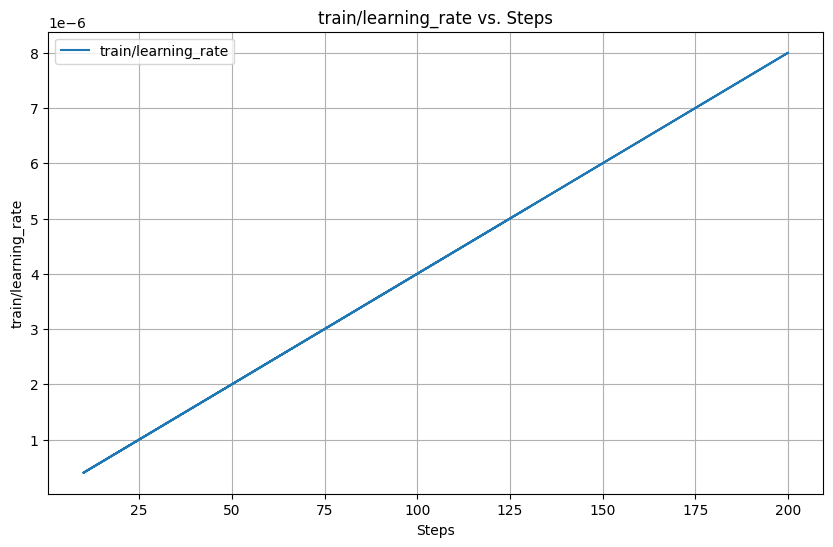

In [96]:
scalar_tag = "train/learning_rate"
visual.plot_scalar_metric(log_dir, scalar_tag)

### Loss x Epochs & Accuracy x Epochs

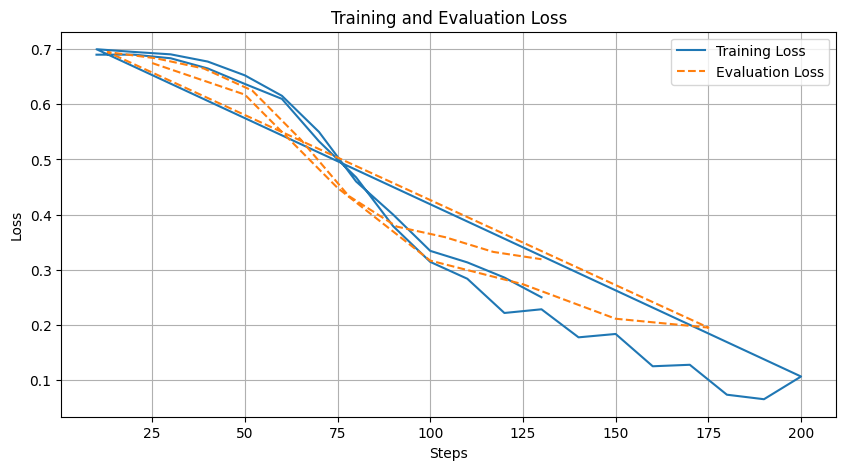

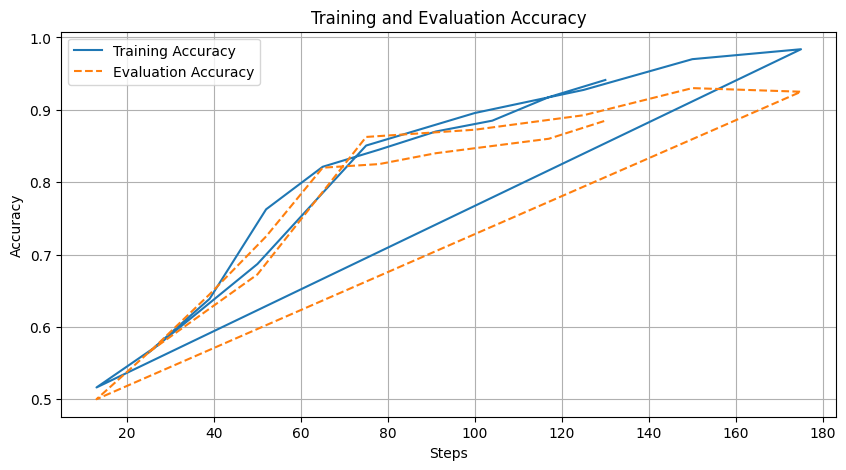

In [97]:
visual.plot_loss_accuracy(extracted_metrics, output_dir)

### Confusion Matrix

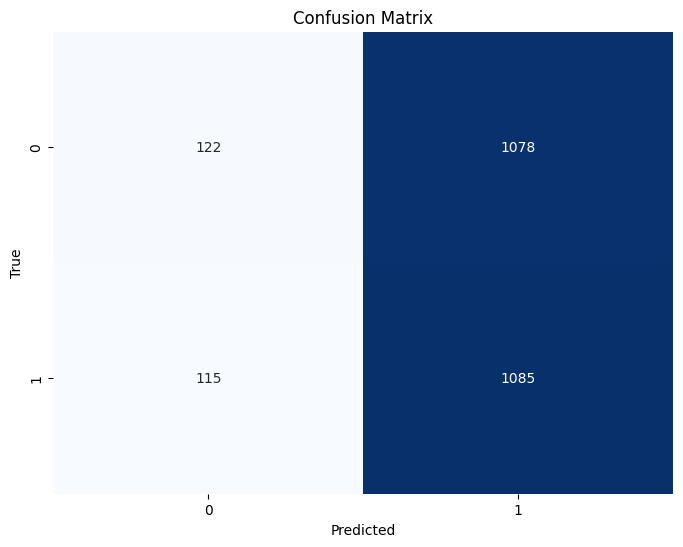

In [98]:
cm = confusion_matrix(true_labels, predicted_labels)
visual.plot_confusion_matrix(cm, output_dir, "test")

### ROC

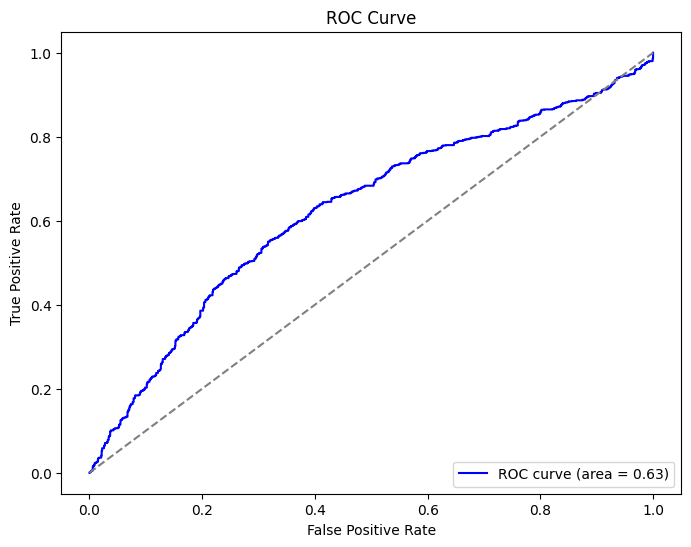

In [99]:
visual.plot_roc_curve(true_labels, probs, output_dir)

### Precision - Recall

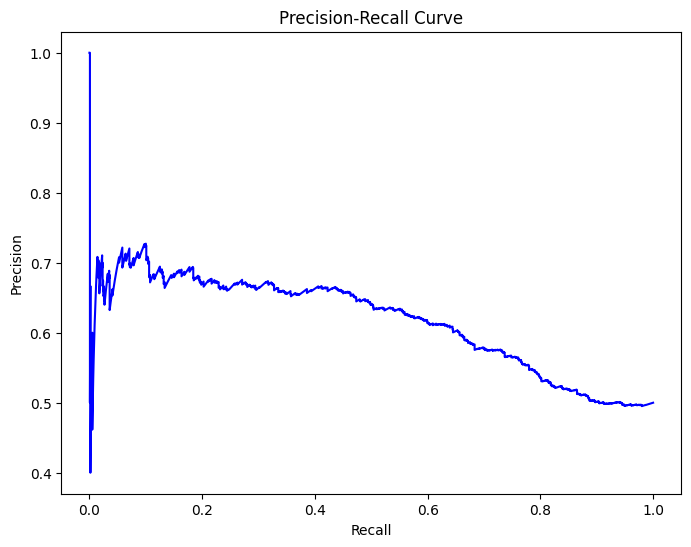

In [100]:
visual.plot_precision_recall(true_labels, probs, output_dir)

### Classification Report

In [101]:
visual.display_classification_report(true_labels, predicted_labels, target_names=["Legitimate", "Phishing"])

,precision,recall,f1-score,support
Legitimate,0.514768,0.101667,0.169798,1200.000000
Phishing,0.501618,0.904167,0.645257,1200.000000
accuracy,0.502917,0.502917,0.502917,0.502917
macro avg,0.508193,0.502917,0.407528,2400.000000
weighted avg,0.508193,0.502917,0.407528,2400.000000


### Inference on samples

In [102]:
s_texts = [
    # Legitimate (0) - Customer addressed with name
    "Dear Frank, your shipment is on its way. Track your order with the tracking number 1234567890. Thank you for shopping with us!",
    
    # Phishing (1) - Generic addressing with urgency
    "Dear user, urgent: Your shipment is delayed. Track your order immediately by clicking this link and providing personal details.",
    
    # Legitimate (0) - Shipment tracking with a proper number
    "Your package has been shipped and is expected to arrive tomorrow. Use the tracking number 9876543210 to track your order in real time.",
    
    # Phishing (1) - Phishing attempt with urgency and a vague request
    "Urgent! Your package has been delayed. Click here to provide your personal information and confirm your tracking number to avoid further delays.",
    
    # Legitimate (0) - Monthly bank statement review
    "Dear Frank, your monthly bank statement is available for review. Please log in to your account to view the full details.",
    
    # Phishing (1) - Urgent account compromise message
    "Your bank account has been compromised! Click this link immediately to verify your identity and secure your account before any further issues occur.",
    
    # Legitimate (0) - Real job application confirmation
    "Hello Frank, we have received your application for the software engineering position. Our team will review it and contact you within a week.",
    
    # Phishing (1) - Fake job application attempt
    "Congratulations, Frank! You've been shortlisted for a job. Please provide your personal information to finalize your application process.",
    
    # Legitimate (0) - Real company promotion (e.g., Easter gift)
    "Happy Easter, Frank! Enjoy a special 15% discount on your next purchase at our store. Use the promo code EASTER15.",
    
    # Phishing (1) - Fake prize scam
    "Congratulations! You've won a $1,000 gift card. To claim your prize, please provide your bank details here."
]

s_true_labels = [
    0, 1, 0, 1, 0, 1, 0, 1, 0, 1
]


In [103]:
s_true_labels, s_predicted_labels, s_probs = bert.inference(
    model, s_texts, s_true_labels, tokenizer,  config['max_len'], device
)

In [104]:
visual.display_inference_results(s_texts, s_true_labels, s_predicted_labels, s_probs, class_names=["Legitimate", "Phishing"])


---- Model Predictions ----

Text: Dear Frank, your shipment is on its way. Track your order with the tracking number 1234567890. Thank you for shopping with us!
True Label: Legitimate
Pred Label: Phishing
     Probs: Legitimate: 0.02, Phishing: 0.98

------------------------------------------------------------

Text: Dear user, urgent: Your shipment is delayed. Track your order immediately by clicking this link and providing personal details.
True Label: Phishing
Pred Label: Phishing
     Probs: Legitimate: 0.02, Phishing: 0.98

------------------------------------------------------------

Text: Your package has been shipped and is expected to arrive tomorrow. Use the tracking number 9876543210 to track your order in real time.
True Label: Legitimate
Pred Label: Phishing
     Probs: Legitimate: 0.03, Phishing: 0.97

------------------------------------------------------------

Text: Urgent! Your package has been delayed. Click here to provide your personal information and confirm you

In [105]:
visual.display_classification_report(s_true_labels, s_predicted_labels, target_names=["Legitimate", "Phishing"])

c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

,precision,recall,f1-score,support
Legitimate,0.00,0.0,0.000000,5.0
Phishing,0.50,1.0,0.666667,5.0
accuracy,0.50,0.5,0.500000,0.5
macro avg,0.25,0.5,0.333333,10.0
weighted avg,0.25,0.5,0.333333,10.0
